In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
import sys
sys.path.append('scripts/')
from simulation_based_likelihood import *
from synthetic_data import *

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 24  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 24  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 30  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 34  # Font size of title

# KL-divergence experiment

Here we show how to run the KL-divergence experiment for a fixed $\iota$

In [3]:
# Small population, basic covariates effect, basic initial variance 
covariates_n = 2

M = 2
N = 100
covmean = 0
initial_infection_rate = 0.01
T = 90

In [11]:
# generate covariates
individuals = np.linspace(0, N-1, N, dtype = int)+1

W = np.random.normal(1, 0, (N, 1))
for i in range(covariates_n-1):

    cov = np.random.normal(covmean, 1, (N, 1))
    W = np.concatenate((W, cov), axis =1)

W_tensor = tf.convert_to_tensor(W, dtype = tf.float32)

input_0      = tuple([W_tensor])
input_kernel = tuple([W_tensor])

# generate the data
model = compartmental_model(N, input_0, input_kernel, SIS_initial, SIS_transition)

beta_0      = tf.convert_to_tensor( [-np.log((1/initial_infection_rate)-1), +0], dtype = tf.float32 )
beta_lambda = tf.convert_to_tensor( [-1,           +2],      dtype = tf.float32 )  
beta_gamma  = tf.convert_to_tensor( [-1,           -1],      dtype = tf.float32 )  
epsilon     = tf.convert_to_tensor( [0.01],                  dtype = tf.float32 )  

parameters_0 = tuple([beta_0])
parameters_kernel = beta_lambda, beta_gamma, epsilon

q_0      = tf.convert_to_tensor([0.0, 0.0], dtype = tf.float32)   
q_static = tf.convert_to_tensor([0.6, 0.4], dtype = tf.float32)

q_0_expanded      = tf.expand_dims(tf.expand_dims(q_0, axis = 0), axis = 0)
q_static_expanded = tf.expand_dims(tf.expand_dims(q_static, axis = 0), axis = 0)

q_dynamic = tf.concat((q_0_expanded*tf.ones((1, N, M)), q_static_expanded*tf.ones((T, N, M))), axis =0)

parameters_emission = tuple([q_static])

# likelihood estimates
parallel_simulations = 100

simulation_likelihood_model = simulation_likelihood(parallel_simulations, N, input_0, input_kernel, SIS_initial, SIS_transition, SIS_emission)

n_experiments = 10

log_likelihood_experiments = np.zeros((n_experiments, N))
log_likelihood_approx_experiments = np.zeros((n_experiments, N))
log_likelihood_approx_experiments_coupled = np.zeros((n_experiments, int(N/2)))

In [12]:
seed_simulation = tfp.random.split_seed( 123, n = n_experiments, salt = 'test')
seed_simulation_1 = tfp.random.split_seed( 123, n = n_experiments, salt = 'test_1')
seed_simulation_2 = tfp.random.split_seed( 123, n = n_experiments, salt = 'test_2')
seed_simulation_3 = tfp.random.split_seed( 123, n = n_experiments, salt = 'test_3')

for i in range(n_experiments):

    x, y = sim(model, parameters_0, parameters_kernel, q_dynamic, T, seed_simulation[i][0])

    seed_test = seed_simulation[i][1]
    while tf.reduce_sum(tf.reduce_sum(x, axis =0), axis =0)[1]<10:
        seed_test = tfp.random.split_seed( seed_test, n = 1, salt = 'new')
        x, y = sim(model, parameters_0, parameters_kernel, q_dynamic, T, seed_test[0])
        seed_test = seed_test[1]

    log_likelihood = run_simulation_likelihood(simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_simulation_1[i][0])

    max_log_likelihood = tf.reduce_max(log_likelihood, axis = 0, keepdims = True)
    log_likelihood_individuals = tf.math.log(tf.reduce_mean(tf.exp(log_likelihood - max_log_likelihood), axis =0)) + tf.reduce_max(log_likelihood, axis = 0)

    log_likelihood_experiments[i,:] = log_likelihood_individuals.numpy()



    log_likelihood_approx = run_simulation_likelihood_approx(simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_simulation_2[i][0])

    max_log_likelihood = tf.reduce_max(log_likelihood_approx, axis = 0, keepdims = True)
    log_likelihood_individuals = tf.math.log(tf.reduce_mean(tf.exp(log_likelihood_approx - max_log_likelihood), axis =0)) + tf.reduce_max(log_likelihood_approx, axis = 0)

    log_likelihood_approx_experiments[i,:] = log_likelihood_individuals



    log_likelihood_approx_coupled = run_simulation_likelihood_coupled(simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_simulation_3[i][0])
     
    max_log_likelihood = tf.reduce_max(log_likelihood_approx_coupled, axis = 0, keepdims = True)
    log_likelihood_individuals = tf.math.log(tf.reduce_mean(tf.exp(log_likelihood_approx_coupled - max_log_likelihood), axis =0)) + tf.reduce_max(log_likelihood_approx_coupled, axis = 0)

    log_likelihood_approx_experiments_coupled[i,:] = log_likelihood_individuals


The above can be iterated on different parameters value and on more experiments as explained in the paper. We report here our studies and how to reproduce the figures in the paper.

## Paper figures

In [25]:
files_in_dir = os.listdir("data/likelihood_covariates_N_variance/current")

files_coupled = []
files_approx = []
files = []

for file in files_in_dir:

    if file[27:33]=="approx":

        if file[34:41]=="coupled":

            files_coupled.append(file)

        else:

            files_approx.append(file)

    else:

        files.append(file)           

files_coupled = np.sort(files_coupled)
files_approx = np.sort(files_approx)
files = np.sort(files)

groups = []
log_likelihood_groups = []
KL_groups = []

for i in range(len(files_approx)):

    element = [files_approx[i][34:], files[i][27:]]

    T = float(files_approx[i][34:].split("_")[0][1:])
    N = float(files_approx[i][34:].split("_")[1][1:])

    log_likelihood_element_approx = np.load("data/likelihood_covariates_N_variance/current/"+files_approx[i])
    log_likelihood_element = np.load("data/likelihood_covariates_N_variance/current/"+files[i])

    emp_likelihood_element_approx = (log_likelihood_element_approx-np.max(log_likelihood_element_approx, axis = 0, keepdims=True))
    emp_likelihood_element_approx = emp_likelihood_element_approx/np.sum(emp_likelihood_element_approx, axis = 0)

    emp_likelihood_element = (log_likelihood_element-np.max(log_likelihood_element, axis = 0, keepdims=True))
    emp_likelihood_element_before = emp_likelihood_element/np.sum(emp_likelihood_element, axis = 0)

    emp_likelihood_element_approx = np.where((emp_likelihood_element_approx==0)*(emp_likelihood_element_before==0), 1e-180*np.ones(emp_likelihood_element_approx.shape), emp_likelihood_element_approx)
    emp_likelihood_element        = np.where((emp_likelihood_element_approx==0)*(emp_likelihood_element_before==0),        1e-180*np.ones(emp_likelihood_element_before.shape),        emp_likelihood_element_before)

    ratio_log = np.log(emp_likelihood_element) - np.log(emp_likelihood_element_approx)

    # print(np.sum(np.isnan(ratio_log)))

    ratio_log[np.isnan(ratio_log) | np.isinf(ratio_log)] = 0

    element_likelihood = [np.sum(log_likelihood_element_approx, axis =1), np.sum(log_likelihood_element, axis =1)]
    
    KL_computation = emp_likelihood_element_before*ratio_log
    element_KL = np.array([np.mean((np.sum(np.concatenate((KL_computation[:i,:], KL_computation[i + 1:,:]), axis =0), axis =0)))/(T) for i in range(KL_computation.shape[0])])

    groups.append(element)
    log_likelihood_groups.append(element_likelihood)
    element_KL = np.where(element_KL>0, element_KL, np.zeros(element_KL.shape))
    KL_groups.append(element_KL*(1e05))

del log_likelihood_groups[-1]
del groups[-1]
del KL_groups[-1]

del log_likelihood_groups[-1]
del groups[-1]
del KL_groups[-1]

C:\Users\loren\AppData\Local\Temp\ipykernel_9004\4091747749.py:50: RuntimeWarning: divide by zero encountered in log
  ratio_log = np.log(emp_likelihood_element) - np.log(emp_likelihood_element_approx)


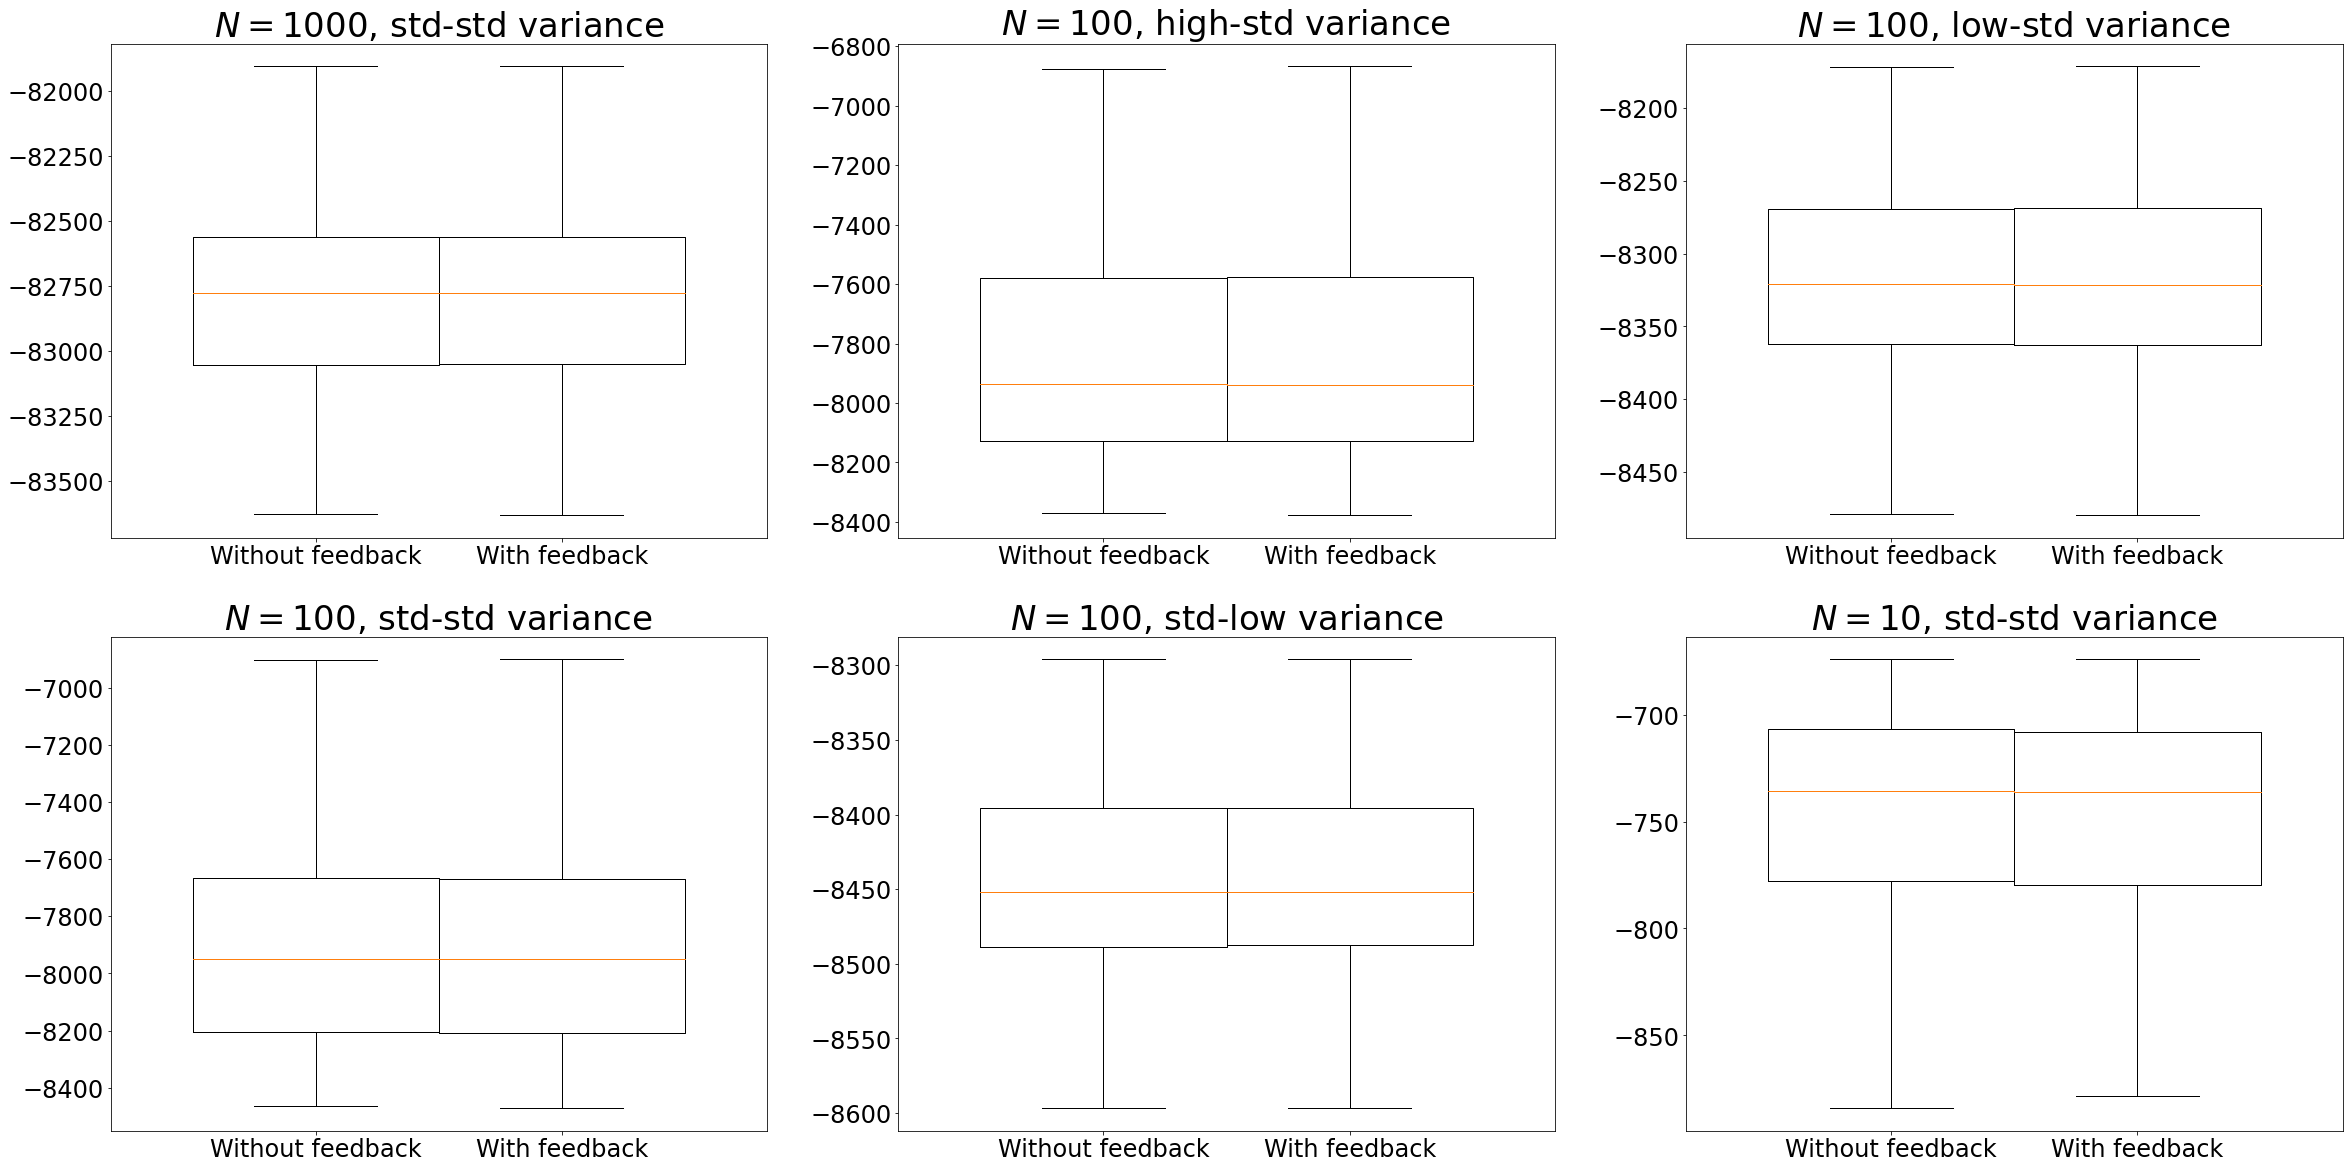

In [27]:
groups = [r"$N=1000$, std-std variance", r"$N=100$, high-std variance", r"$N=100$, low-std variance", r"$N=100$, std-std variance", r"$N=100$, std-low variance", r"$N=10$, std-std variance", ]

# Set up the figure
fig, ax = plt.subplots(nrows=2, ncols=int(len(groups)/2), figsize = (40, 20))

for i in range(2):

    for j in range(int(len(groups)/2)):

        position = [1, 1.6]

        # Plot the boxplots for each group, closer together
        ax[i, j].boxplot(log_likelihood_groups[i*(int(len(groups)/2)) + j], positions=position, widths=0.6, showfliers=False)

        ax[i, j].set_title(groups[i*(int(len(groups)/2)) + j]) 
        ax[i, j].set_xticklabels(['Without feedback', 'With feedback'])

In [28]:
table = []

for i in range(len(groups)):
    empty_list = []

    empty_list.append(groups[i])

    table.append(empty_list)

for i in range(len(table)):

    table[i].append(str(np.round(np.mean(KL_groups[i]), 3))+"("+str(np.round(np.std(KL_groups[i]), 3))+")")

In [29]:
groups = []
log_likelihood_groups = []
KL_groups = []

for i in range(len(files_approx)):

    element = [files_approx[i][34:], files_coupled[i][42:]]

    log_likelihood_element_approx = np.load("data/likelihood_covariates_N_variance/current/"+files_approx[i])

    N = log_likelihood_element_approx.shape[1]
    indeces_even = np.linspace(0, N-2, int(N/2), dtype = int)
    indeces_odd  = np.linspace(1, N-1, int(N/2), dtype = int)

    log_likelihood_element_approx = log_likelihood_element_approx[:,indeces_even] + log_likelihood_element_approx[:,indeces_odd]

    log_likelihood_element = np.load("data/likelihood_covariates_N_variance/current/"+files_coupled[i])

    emp_likelihood_element_approx = (log_likelihood_element_approx-np.max(log_likelihood_element_approx, axis = 0, keepdims=True))
    emp_likelihood_element_approx = emp_likelihood_element_approx/np.sum(emp_likelihood_element_approx, axis = 0)

    emp_likelihood_element = (log_likelihood_element-np.max(log_likelihood_element, axis = 0, keepdims=True))
    emp_likelihood_element_before = emp_likelihood_element/np.sum(emp_likelihood_element, axis = 0)

    emp_likelihood_element_approx = np.where((emp_likelihood_element_approx==0)*(emp_likelihood_element_before==0), 1e-180*np.ones(emp_likelihood_element_approx.shape), emp_likelihood_element_approx)
    emp_likelihood_element        = np.where((emp_likelihood_element_approx==0)*(emp_likelihood_element_before==0),        1e-180*np.ones(emp_likelihood_element_before.shape),        emp_likelihood_element_before)

    ratio_log = np.log(emp_likelihood_element) - np.log(emp_likelihood_element_approx)

    # print(np.sum(np.isnan(ratio_log)))

    ratio_log[np.isnan(ratio_log) | np.isinf(ratio_log)] = 0

    element_likelihood = [np.sum(log_likelihood_element_approx, axis =1), np.sum(log_likelihood_element, axis =1)]
    
    T = float(files_approx[i][34:].split("_")[0][1:])
    N = float(files_approx[i][34:].split("_")[1][1:])
    
    KL_computation = emp_likelihood_element_before*ratio_log
    element_KL = np.array([np.mean((np.sum(np.concatenate((KL_computation[:i,:], KL_computation[i + 1:,:]), axis =0), axis =0)))/(T) for i in range(KL_computation.shape[0])])

    groups.append(element)
    log_likelihood_groups.append(element_likelihood)
    element_KL = np.where(element_KL>0, element_KL, np.zeros(element_KL.shape))
    KL_groups.append(element_KL*(1e05))



del log_likelihood_groups[-1]
del groups[-1]
del KL_groups[-1]

del log_likelihood_groups[-1]
del groups[-1]
del KL_groups[-1]

C:\Users\loren\AppData\Local\Temp\ipykernel_9004\208505964.py:28: RuntimeWarning: divide by zero encountered in log
  ratio_log = np.log(emp_likelihood_element) - np.log(emp_likelihood_element_approx)


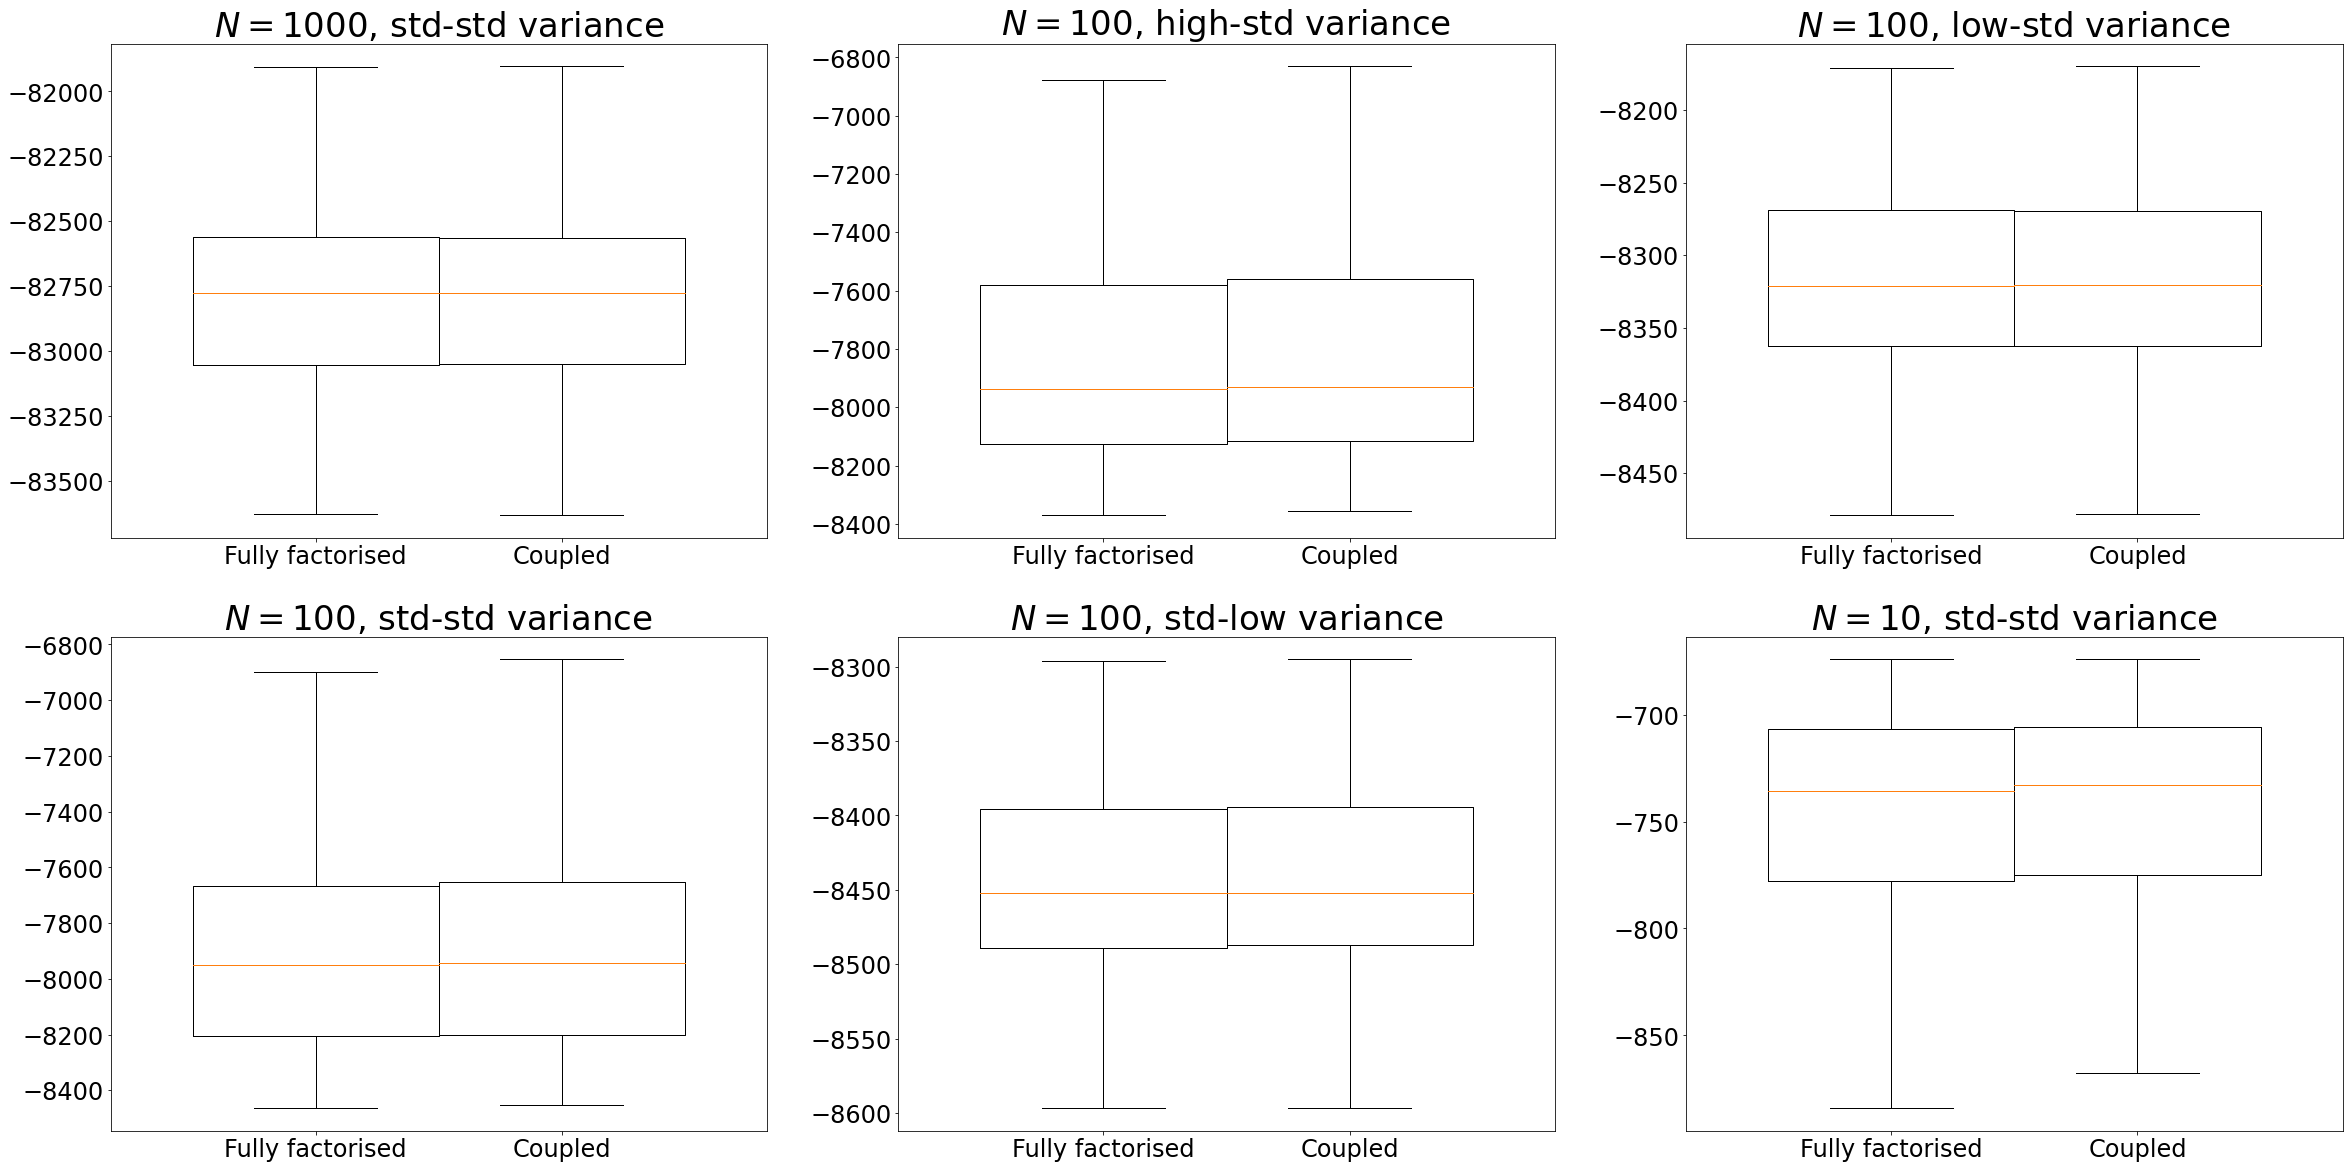

In [30]:
groups = [r"$N=1000$, std-std variance", r"$N=100$, high-std variance", r"$N=100$, low-std variance", r"$N=100$, std-std variance", r"$N=100$, std-low variance", r"$N=10$, std-std variance", ]

fig, ax = plt.subplots(nrows=2, ncols=int(len(groups)/2), figsize = (40, 20))

for i in range(2):

    for j in range(int(len(groups)/2)):

        position = [1, 1.6]

        # Plot the boxplots for each group, closer together
        ax[i, j].boxplot(log_likelihood_groups[i*(int(len(groups)/2)) + j], positions=position, widths=0.6, showfliers=False)#, showmeans=True)

        ax[i, j].set_title(groups[i*(int(len(groups)/2)) + j]) 
        ax[i, j].set_xticklabels(['Fully factorised', 'Coupled'])

In [31]:
for i in range(len(table)):
    
    table[i].append(str(np.round(np.mean(KL_groups[i]), 3))+"("+str(np.round(np.std(KL_groups[i]), 3))+")")

In [32]:
from tabulate import tabulate

table_to_print = tabulate(table, headers=["Framework", "With vs Without", "Uncoupled vs Coupled"], tablefmt="fancy_grid")
print(table_to_print)

╒════════════════════════════╤═══════════════════╤════════════════════════╕
│ Framework                  │ With vs Without   │ Uncoupled vs Coupled   │
╞════════════════════════════╪═══════════════════╪════════════════════════╡
│ $N=1000$, std-std variance │ 0.003(0.002)      │ 0.014(0.003)           │
├────────────────────────────┼───────────────────┼────────────────────────┤
│ $N=100$, high-std variance │ 0.075(0.032)      │ 0.361(0.066)           │
├────────────────────────────┼───────────────────┼────────────────────────┤
│ $N=100$, low-std variance  │ 0.008(0.004)      │ 0.03(0.009)            │
├────────────────────────────┼───────────────────┼────────────────────────┤
│ $N=100$, std-std variance  │ 0.059(0.029)      │ 0.351(0.07)            │
├────────────────────────────┼───────────────────┼────────────────────────┤
│ $N=100$, std-low variance  │ 0.014(0.01)       │ 0.056(0.02)            │
├────────────────────────────┼───────────────────┼────────────────────────┤
│ $N=10$, st